### TP4: univariate GANs for financial time series with GMM and relativistic losses


Libraries import

In [128]:

import datetime
import sys
import os
import pickle
import numpy                     as np
import pandas                    as pd
import matplotlib.pyplot         as plt
import tensorflow                as tf
import tensorflow_probability    as tfp
import tensorflow.keras.backend  as K
from time                        import time
from tensorflow                  import keras
from keras.models                import Sequential
from keras.layers                import Dense
from keras.layers                import Activation
from keras.layers                import Input
from keras.models                import Model
from keras.layers                import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers     import Concatenate
from tensorflow.keras.utils      import Progbar
from sklearn.utils               import shuffle
from sklearn.preprocessing       import StandardScaler
from tensorflow.keras.models     import save_model
from tensorflow.keras.models     import load_model

In [129]:
scaler=StandardScaler()

In [130]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [131]:
mydata=pd.read_csv("sp500_20161229.csv") #change path accordingly
rets=np.hstack(mydata.values[:,1:].T)
rets=rets.astype(float)
rets=rets[np.isfinite(rets)]

In [132]:
T=1000
num_GMMs=6
dim_noise=5000
nu=3

INIT_LR = 1e-5
bias=False 
activation_generator="selu"
activation_discriminator="PReLU"

num_epochs=300
epoch_range=np.arange(1,num_epochs+1)
batch_size=50
num_batches_per_epoch=int(len(rets)/batch_size)
losses=[]

generator_type="Dense"

In [133]:
n_samples_data=10000  
#t0s=np.random.choice(len(rets)-T,size=n_samples_data)
    
rets_sample=[rets[range(i,i+T)] for i in np.random.choice(len(rets)-T,size=n_samples_data)]
X=np.array(rets_sample)         # list -> 2d-array
X.shape

(10000, 1000)

In [134]:
#Relevant statistics
def compute_GMM(X):

     mean_returns = tf.reduce_mean(X,axis=1)
     std_returns = tf.math.reduce_std(X,axis=1)
     third_moment_returns = tf.reduce_mean(tf.math.pow(X - tf.expand_dims(mean_returns, axis=1), 3), axis=1)
     fourth_moment_returns = tf.reduce_mean(tf.math.pow(X - tf.expand_dims(mean_returns, axis=1), 4), axis=1)
     kurtosis_returns = fourth_moment_returns / (tf.math.pow(std_returns, 4)) - 3

     min_returns = tf.reduce_min(X,axis=1)
     max_returns = tf.reduce_max(X,axis=1)
     
     stats = tf.stack([mean_returns, std_returns, third_moment_returns, fourth_moment_returns, kurtosis_returns,  min_returns,max_returns],axis=1)
     
     return stats

In [135]:
'''def compute_GMM(input) :

  centered_data = input - tf.reduce_mean(input, axis=1,keepdims=T)
  variance = tf.reduce_mean(centered_data ** 2, axis=1)
  mean = tf.reduce_mean(input, axis=1)
  skew = tf.reduce_mean(centered_data ** 3, axis=1)
  kurt = tf.reduce_mean(centered_data ** 4, axis=1)
  moment_5 = tf.reduce_mean(centered_data ** 5, axis=1)
  moment_6 = tf.reduce_mean(centered_data ** 6, axis=1)

  moments = tf.stack([mean, variance, skew, kurt, moment_5, moment_6],axis=1)
  return moments'''

'def compute_GMM(input) :\n\n  centered_data = input - tf.reduce_mean(input, axis=1,keepdims=T)\n  variance = tf.reduce_mean(centered_data ** 2, axis=1)\n  mean = tf.reduce_mean(input, axis=1)\n  skew = tf.reduce_mean(centered_data ** 3, axis=1)\n  kurt = tf.reduce_mean(centered_data ** 4, axis=1)\n  moment_5 = tf.reduce_mean(centered_data ** 5, axis=1)\n  moment_6 = tf.reduce_mean(centered_data ** 6, axis=1)\n\n  moments = tf.stack([mean, variance, skew, kurt, moment_5, moment_6],axis=1)\n  return moments'

In [136]:
def relativistic_average(input_):
    x_0 = input_[0]
    x_1 = input_[1]
    return x_0 - K.mean(x_1, axis=0)

LOSS='binary_crossentropy'
OPT = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, beta_1=0.8, beta_2=0.995)

In [137]:
def generator_builder(T,dim_noise,activation="relu",use_bias=True):
    noise = Input(shape = (dim_noise,))
    Layer_1 = Dense(32, activation=activation, use_bias=use_bias)(noise)
    Layer_2 = Dense(64, activation=activation, use_bias=use_bias)(Layer_1)
    output = Dense(T, activation="linear", use_bias=use_bias)(Layer_2)
    generator = Model(inputs= noise,outputs = output)
    return generator

def discriminator_builder(num_GMMs,T,activation="relu",use_bias=True):
    input  = Input(shape = (T,))
    lambda_out = Lambda(lambda x: compute_GMM(x), name='gmm_output')(input)
    Dense1 = Dense(int(num_GMMs//2),activation = activation)(lambda_out)
    output = Dense(1,activation = 'sigmoid')(Dense1)
    discriminator = Model(inputs = input, outputs = output)
    return discriminator


discriminator=discriminator_builder(num_GMMs,T,use_bias=bias,activation=activation_discriminator)
generator    =generator_builder(T,dim_noise,use_bias=bias,activation=activation_generator)


In [138]:
discriminator.compile(OPT, loss=LOSS)
discriminator.build(input_shape=(2*batch_size,T))
discriminator.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1000)]            0         
                                                                 
 gmm_output (Lambda)         (None, 7)                 0         
                                                                 
 dense_34 (Dense)            (None, 3)                 27        
                                                                 
 dense_35 (Dense)            (None, 1)                 4         
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [139]:


Real_data                          = Input(shape=X.shape[1:])
Noise_input                        = Input(shape=(dim_noise))

Fake_data                          = generator(Noise_input)
Discriminator_real_out             = discriminator(Real_data)
Discriminator_fake_out             = discriminator(Fake_data)
Real_Fake_relativistic_average_out = Lambda(relativistic_average, name='Real_minus_mean_fake')([Discriminator_real_out, Discriminator_fake_out])
Fake_Real_relativistic_average_out = Lambda(relativistic_average, name='Fake_minus_mean_real')([Discriminator_fake_out, Discriminator_real_out])

Real_Fake_relativistic_average_out = Activation('sigmoid')(Real_Fake_relativistic_average_out)
Fake_Real_relativistic_average_out = Activation('sigmoid')(Fake_Real_relativistic_average_out)

In [140]:
Discriminator_Relativistic_out = Concatenate()([Real_Fake_relativistic_average_out, Fake_Real_relativistic_average_out])

generator_train = Model([Noise_input, Real_data], Discriminator_Relativistic_out)
discriminator.trainable=False
generator_train.compile(OPT, loss=LOSS)
generator_train.summary()
#SVG(model_to_dot(generator_train, show_shapes=True).create(prog='dot', format='svg'))

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 5000)]               0         []                            
                                                                                                  
 input_25 (InputLayer)       [(None, 1000)]               0         []                            
                                                                                                  
 model_23 (Functional)       (None, 1000)                 226048    ['input_26[0][0]']            
                                                                                                  


 model_22 (Functional)       (None, 1)                    31        ['input_25[0][0]',            
                                                                     'model_23[0][0]']            
                                                                                                  
 Real_minus_mean_fake (Lamb  (None, 1)                    0         ['model_22[0][0]',            
 da)                                                                 'model_22[1][0]']            
                                                                                                  
 Fake_minus_mean_real (Lamb  (None, 1)                    0         ['model_22[1][0]',            
 da)                                                                 'model_22[0][0]']            
                                                                                                  
 activation_10 (Activation)  (None, 1)                    0         ['Real_minus_mean_fake[0][0]']
          

In [141]:
discriminator_train = Model([Noise_input, Real_data],Discriminator_Relativistic_out)
generator.trainable = False
discriminator.trainable=True
discriminator_train.summary()
discriminator_train.compile(OPT, loss=LOSS)
#SVG(model_to_dot(discriminator_train, show_shapes=True).create(prog='dot', format='svg'))

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 5000)]               0         []                            
                                                                                                  
 input_25 (InputLayer)       [(None, 1000)]               0         []                            
                                                                                                  
 model_23 (Functional)       (None, 1000)                 226048    ['input_26[0][0]']            
                                                                                                  
 model_22 (Functional)       (None, 1)                    31        ['input_25[0][0]',            
                                                                     'model_23[0][0]']     

In [142]:
true_y = np.ones((batch_size, 1), dtype=np.float32)
fake_y = np.zeros((batch_size, 1), dtype=np.float32)
y_for_dis = np.concatenate((true_y, fake_y), axis=1)
y_for_gen = np.concatenate((fake_y, true_y), axis=1)

TRAINING_RATIO=1

discriminator_loss=[]
generator_loss=[]

In [143]:
for epoch in range(num_epochs):
    
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, num_epochs))
    num_batches = int(X.shape[0] // batch_size)
    minibatches_size = batch_size * (TRAINING_RATIO+1)
    print("number of batches: {}".format(int(X.shape[0] // (minibatches_size))))
    print("minibatches_size: "+str(minibatches_size))
    print("num_batches "+str(num_batches))
    
    progress_bar = Progbar(target=int(X.shape[0] // minibatches_size))

    start_time = time()
    for index in range(int(X.shape[0] // (minibatches_size))):
        progress_bar.update(index)
        iteration_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]

        for j in range(TRAINING_RATIO):
            data_batch = iteration_minibatches[j * batch_size : (j + 1) * batch_size]
            noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(discriminator_train.train_on_batch([noise, data_batch],y_for_dis))
            
        data_batch = iteration_minibatches[TRAINING_RATIO*batch_size : (TRAINING_RATIO + 1) * batch_size]
        noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(generator_train.train_on_batch([noise, data_batch], y_for_gen))

    print('\nepoch time: {}'.format(time()-start_time))
    
    test_noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
   
    generated_data = generator.predict(test_noise)


epoch 1 of 300
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
epoch time: 15.777788877487183
2/2 [==============================] - 0s 5ms/step
epoch 2 of 300
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
epoch time: 13.70303225517273
2/2 [==============================] - 0s 4ms/step
epoch 3 of 300
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
epoch time: 13.278481006622314
2/2 [==============================] - 0s 5ms/step
epoch 4 of 300
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
epoch time: 15.13330888748169
2/2 [==============================] - 0s 7ms/step
epoch 5 of 300
number of batches: 100
minibatches_size: 100
num_batches 200
 99/100 [============================>.] - ETA: 0s
epoch time: 13.544774770736694
2/2 [===

In [153]:
'''save_model(generator, 'generator.h5')
save_model(discriminator,'discriminator.h5')'''

C:\Users\Win10-Space\AppData\Local\Temp\ipykernel_11912\2200431785.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(generator, 'generator.h5')
C:\Users\Win10-Space\AppData\Local\Temp\ipykernel_11912\2200431785.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(discriminator,'discriminator.h5')


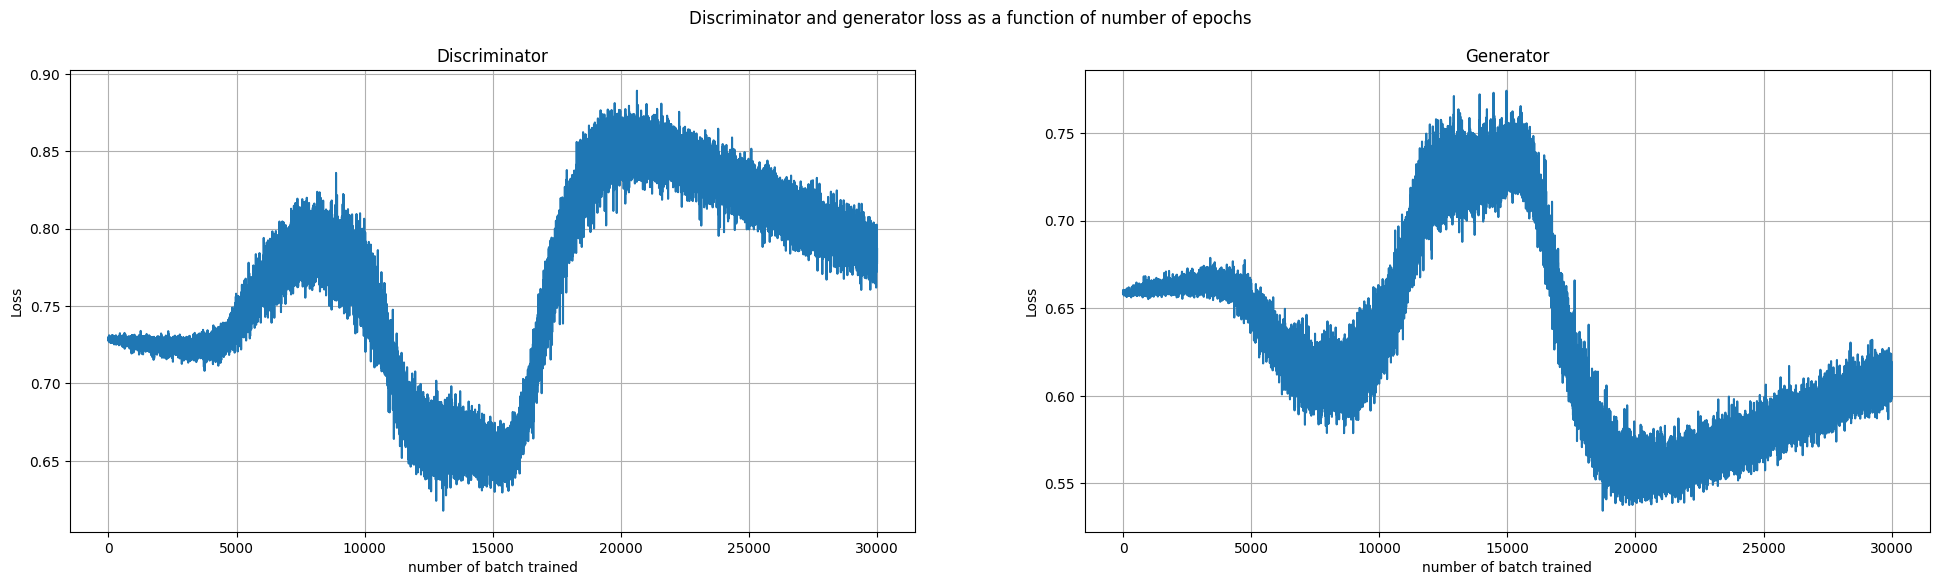

In [148]:
#Plotting Discriminator and generator loss 
fig, axs = plt.subplots(1,2,figsize=(24,6))
fig.suptitle(r'Discriminator and generator loss as a function of number of epochs')

axs[0].set_title(r'Discriminator')
axs[1].set_title(r'Generator')

axs[0].plot(np.arange(len(discriminator_loss)),discriminator_loss)
axs[1].plot(np.arange(len(generator_loss)),generator_loss)

for i in [0,1]:
    axs[i].set_xlabel(r'number of batch trained')
    axs[i].set_ylabel(r'Loss')
    axs[i].grid()


plt.show()

We notice that the loss of Discrimantor and that of generator act in an inversed manner i.e a decrease of disciminator loss results in an increase of Generator loss and vice-versa. Also it seems like there is a convergence tendancy for greater number of batch trained.

In [149]:
test_noise = np.random.standard_t(nu,size=(batch_size, dim_noise))/np.sqrt(nu/(nu-2)).astype(np.float32)
   
generated_data = generator.predict(test_noise)

2/2 [==============================] - 0s 6ms/step


In [150]:
generated_data.shape

(50, 1000)

In [159]:
random_vector = np.random.randint(1, generated_data.shape[0], size=4)


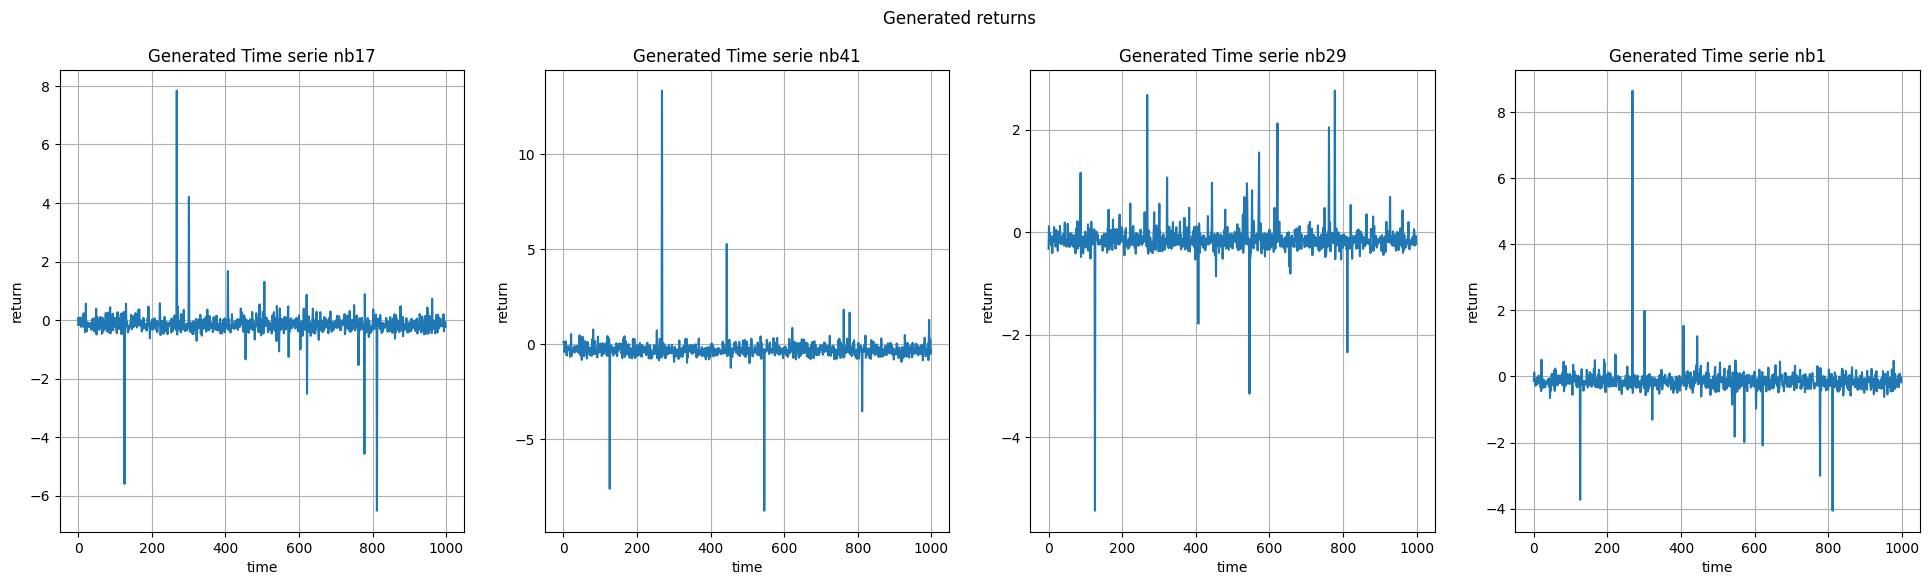

In [162]:
fig, axs = plt.subplots(1,4,figsize=(24,6))
fig.suptitle(r'Generated returns')

for i in [0,1,2,3]:
    axs[i].set_title('Generated Time serie nb'+str(random_vector[i]))
    axs[i].plot(np.arange(generated_data.shape[1]),generated_data[random_vector[i]])
    axs[i].set_xlabel(r'time')
    axs[i].set_ylabel(r'return')
    axs[i].grid()

plt.show()

Q6) Added statistics influence the generated time series (comparision with other students results)

Q7) convergence of discrimnator and generator losses garanties a stability in the results but it doesn't necessarly mean better results (actually the convergence loss value for the generator loss can be greater than the minimum it reached before convergence)